# Preparing dataset
This notebook is explaining how to create a dataset usable for Convolutional Neural Networks consisting of Sentinel-1 and Sentinel-3 images. It is meant as a proof of concept notebook and is thus not creating an entire dataset, but only a testset. The notebook contains:

- Loading both Sentinel-1 and Sentinel-3 images in Python

- Illustrating Sentinel-1 and Sentinel-3 images in Python

- Using knowlegde on the 2019 Ljusdal fire(see report) and Sentinel-3 RGB image to define centroids of fire and centroids of no fire

- Using centroids to define boxes.

- Save boxes as arrays with 1 and 5 bands respectivly.

- Saving arrays as images in their designated folders.

- labelling the images with binary classes, belonging to either fire or no_fire.


-------------
Importing the needed packages and paths

In [4]:
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#folder where images will be saved (and loaded)
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\data\\NN_test')
#Folder with my own functions(my_s1 and my_modis)
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\code')
#Folder where im fetching the data from
sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\data\\s1')
#my functions
import my_s1 as s1
import my_s3 as s3
import my_modis as modis
import my_tools as tools
import my_cnn as cnn

Using TensorFlow backend.


# Loading Images

Firslty, working with sentinel 1 images. This is made as a test. Therefore, one s1 image will be loaded in which a known fire is present (as known from the report made by the swedish goverment in 2018). This image will firstly be cropped to a smaller image. 

Then, several centroids will be defined by their row and column. These centroids are placed where there is a fire and using them, a box with size 500x500 pixels will be made.  These boxes then contain fires. Then, the boxes will be saved in their fire folder.


Next, the same will be done, but with boxes in which no fires are present. These will then be saved in the no_fire folder.

--------------------

### Getting image paths

Get s1 images using my own functions.




In [185]:
folder_path_s1 = "C:\\Users\krist\Documents\Syntese\data\collocate_testfolder\d_23\s1s3\subsets"
folder_path_s3 = "C:\\Users\krist\Documents\Syntese\data\s3\Analyse_23"
img_paths_s1 = tools.file_paths(folder_path_s1,verbose=1,file_type='tif')
img_paths_s3 = tools.file_paths(folder_path_s3,verbose=1,file_type='tif')
print(*(i for i in img_paths_s1), sep='\n')
print(*(i for i in img_paths_s3), sep='\n')


there are: 2  . tif  files in folder

there are: 5  . tif  files in folder
C:\Users\krist\Documents\Syntese\data\collocate_testfolder\d_23\s1s3\subsets\d23_s1.tif
C:\Users\krist\Documents\Syntese\data\collocate_testfolder\d_23\s1s3\subsets\d23_s3.tif
C:\Users\krist\Documents\Syntese\data\s3\Analyse_23\subset_1_of_collocate.tif
C:\Users\krist\Documents\Syntese\data\s3\Analyse_23\subset_1_of_collocate_resampled.tif
C:\Users\krist\Documents\Syntese\data\s3\Analyse_23\subset_2_of_subset_0_of_S3A_SL_1_RBT____20180723T092851_20180723T093151_20180724T140918_0179_033_364_1980_LN2_O_NT_003.tif
C:\Users\krist\Documents\Syntese\data\s3\Analyse_23\qgis\1.tif
C:\Users\krist\Documents\Syntese\data\s3\Analyse_23\qgis\s3_analyse_1.tif


As we can see, there are two tif files here. Looking as the names, we see it is a Sentinel-1 and Sentinel-3 images respecticly, both aquired on the 23th of july.

------------
### Load images

In [186]:
s1_img,s1_raster,s1_extend, s1_names, s1_extra = s1.get_img([img_paths_s1[0]],data_type='ENVI')
s3_img,s3_raster,s3_extend, s3_names, s3_extra = s3.get_img([img_paths_s3[1]],data_type='ENVI')

--------------------------
Sentinel-1 image is loading

1 image is being loaded
image 1
There are 2 bands


Displaying the entire image with latitude and longitude, which is easier to understand.

for the picture chosen(23 july), both the VV and VH bands are aquired. These will both be used

### Illustrating images
Now, each band belonging to the two images witll be shown. Lastly, the false RGB image from Sentinel-3 will be shown...

For better illustrations, see the report. The illustrations below are just meant for verifications. 

--------------------------------
### Illustrate Sentinel-1

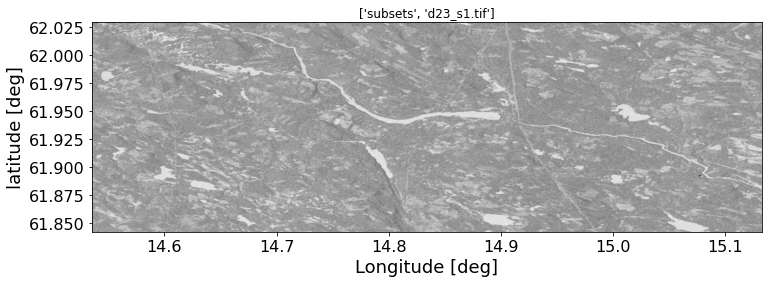

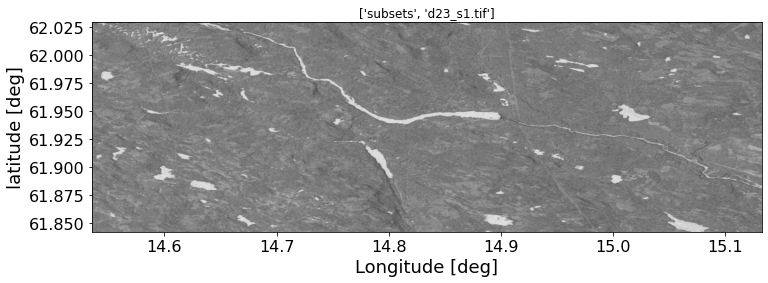

In [6]:
for n in range(len(s1_img)):
    s1.s1_show(s1_img[n],s1_extend[math.ceil(n/2)],s1_names[math.ceil(n/2)])

The above two pictures are the VV and VH band respectivly, as calibrated and preprocsed in esa SNAP.

--------------------------------
### Illustrate Sentinel-3

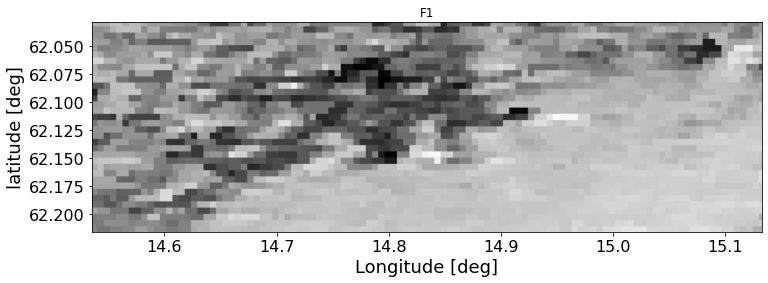

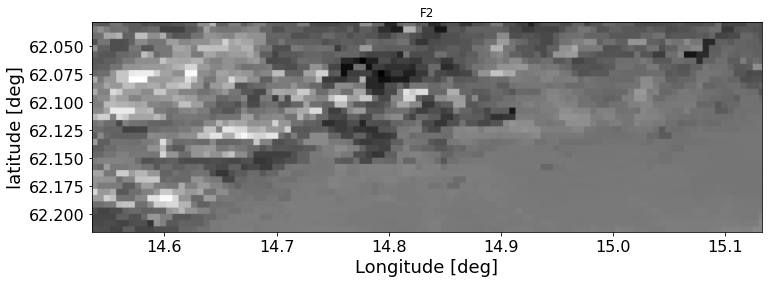

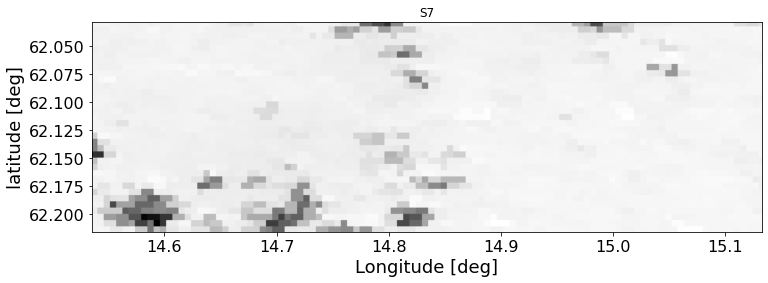

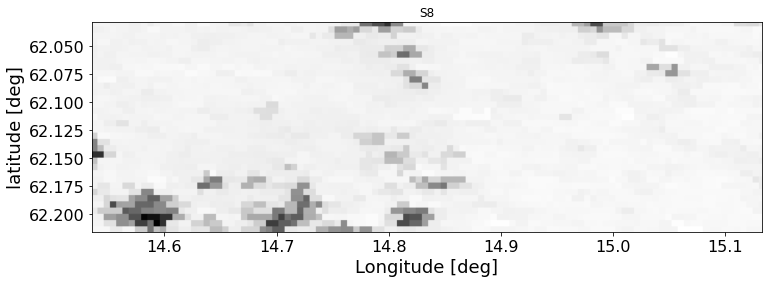

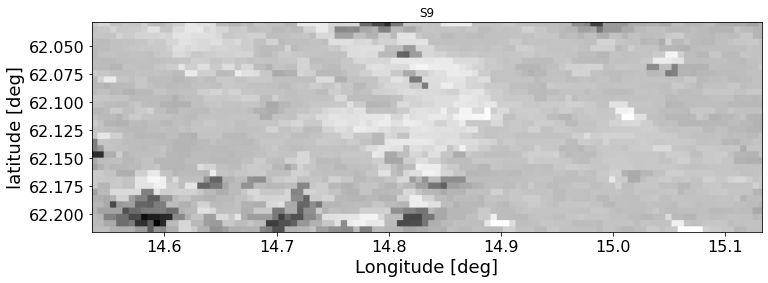

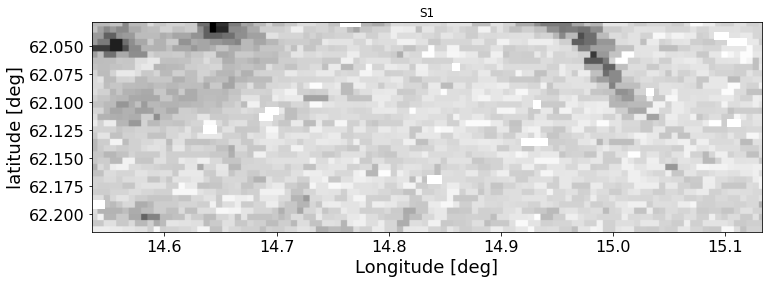

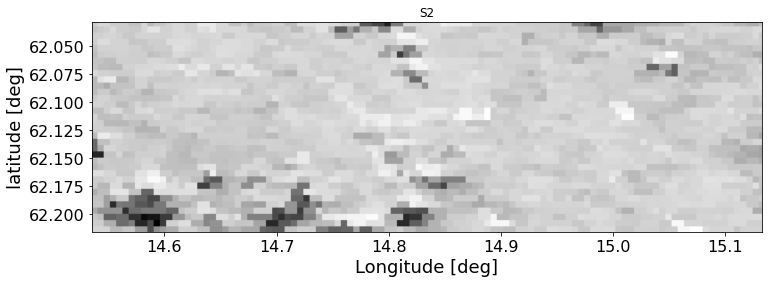

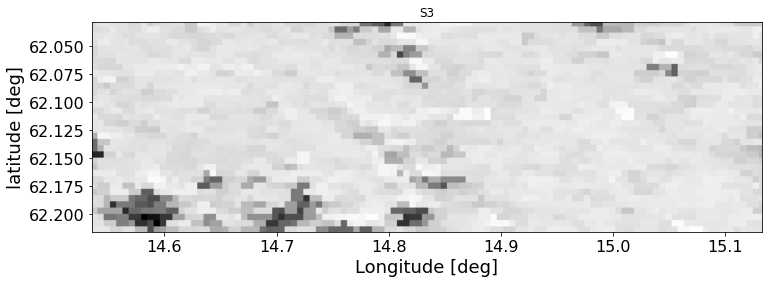

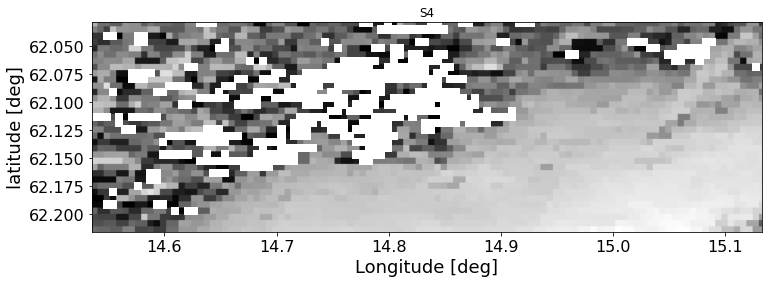

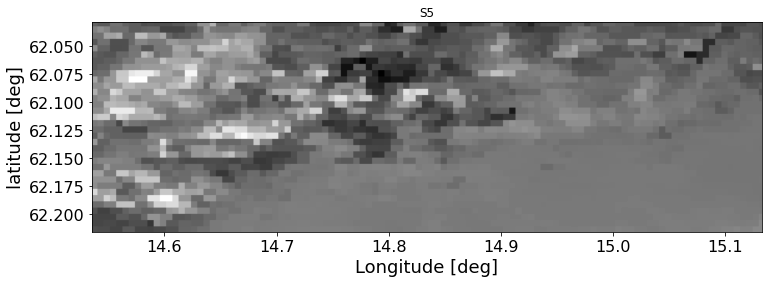

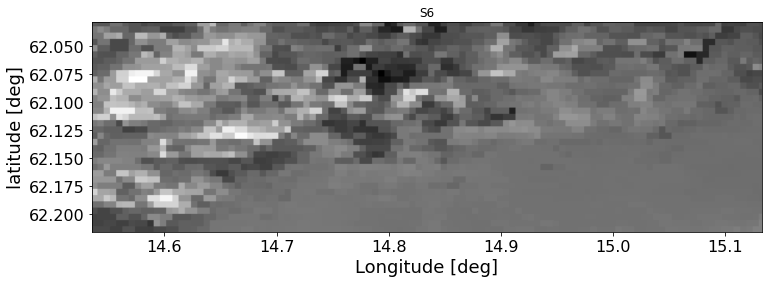

In [7]:
for n in range(len(s3_img)):
    s3.s3_show(s3_img[n],s3_extend[math.ceil(n/2)],s3_names[n])

In [4]:
#nadir_false_colour_RGB = tools.color_img(tools.img_stretch(s3_img[4],0,255),tools.img_stretch(s3_img[2],0,255),tools.img_stretch(s3_img[1],0,255))
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
band_names = ['F1','F2','S1','S2','S3','S4','S5','S6','S7','S8','S9']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


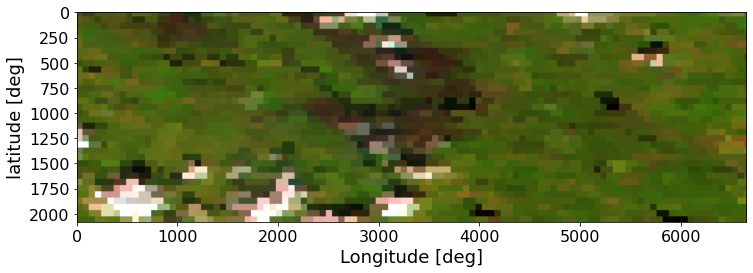

In [188]:
nadir_false_colour_RGB = tools.color_img(tools.img_stretch(s3_img[6],0,255),tools.img_stretch(s3_img[4],0,255),tools.img_stretch(s3_img[3],0,255))
fig, axs = plt.subplots(figsize=(12,6), facecolor='w', edgecolor='k') 
axs.imshow(nadir_false_colour_RGB)
plt.xlabel('Longitude [deg]', fontsize=18)
plt.ylabel('latitude [deg]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

Now, for noth the Sentinel-1 and Sentinel-3 images, a training set will be made. The training set will consist of boxes of size 200x200. The boxes will be made over areas of fire and no_fire respectilvy. 


The size of 200x200 is picked arbitrarily and has not been examined further. The size of 200x200 is belived to be "big enough" to contain spatial information of the fire, and yet "small" enough to be computational good. Also, since a single image is used to make the CNN, the boxes should be "small enough", so it would be possible to define several boxes.
## Defining box centroids


In [49]:
folder_path = "C:\\Users\\krist\\Documents\\Syntese\\data\Hand_in\\files_from_images\\image_pair_1"

img_paths = tools.file_paths(folder_path,verbose=1,file_type='tif')
print(*(i for i in img_paths_s1), sep='\n')

s1_img,s1_raster,s1_extend, s1_names, s1_extra = s1.get_img([img_paths[0]],data_type='ENVI')
s3_img,s3_raster,s3_extend, s3_names, s3_extra = s3.get_img([img_paths[1]],data_type='ENVI')


there are: 2  . tif  files in folder
C:\Users\krist\Documents\Syntese\data\collocate_testfolder\d_23\s1s3\subsets\d23_s1.tif
C:\Users\krist\Documents\Syntese\data\collocate_testfolder\d_23\s1s3\subsets\d23_s3.tif
--------------------------
Sentinel-1 image is loading

1 image is being loaded
image 1
There are 3 bands


From the knowlagde on the fire, aquired from the report, it is possible to define centroids of fire and no_fire boxes, as illustrated on the Sentinel-3 False coloured RGB image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


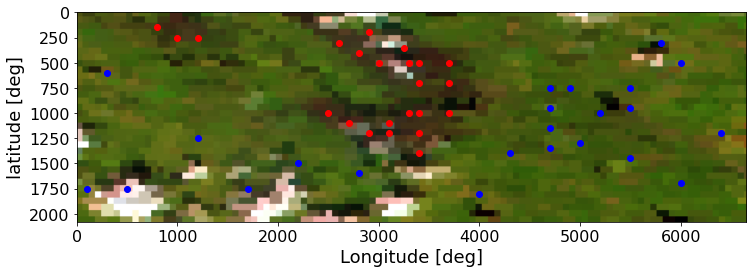

In [205]:
fig, axs = plt.subplots(figsize=(12,6), facecolor='w', edgecolor='k') 
axs.imshow(nadir_false_colour_RGB)
plt.xlabel('Longitude [deg]', fontsize=18)
plt.ylabel('latitude [deg]', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#fire
plt.scatter(3100,1100,c='r')
plt.scatter(3400,700,c='r')
plt.scatter(3400,1200,c='r')
plt.scatter(2500,1000,c='r')
plt.scatter(3400,1400,c='r')
plt.scatter(3000,500,c='r')
plt.scatter(2800,400,c='r')
plt.scatter(3700,700,c='r')
plt.scatter(2600,300,c='r')
plt.scatter(1000,250,c='r')
plt.scatter(1200,250,c='r')

#no fire
plt.scatter(4000,1800,c='b')
plt.scatter(1200,1250,c='b')
plt.scatter(4700,750,c='b')
plt.scatter(2800,1600,c='b')
plt.scatter(4300,1400,c='b')
plt.scatter(5000,1300,c='b')
plt.scatter(300,600,c='b')
plt.scatter(2200,1500,c='b')
plt.scatter(5200,1000,c='b')
plt.scatter(6000,500,c='b')
plt.scatter(6000,1700,c='b')
#defining each scatter as done above is super ineffecient, but whatever. It worked for so few points.

plt.scatter(4900,750,c='b')
plt.scatter(4700,950,c='b')
plt.scatter(4700,1150,c='b')
plt.scatter(4700,1350,c='b')
plt.scatter(5500,750,c='b')
plt.scatter(5500,950,c='b')
plt.scatter(5500,1450,c='b')
plt.scatter(500,1750,c='b')
plt.scatter(100,1750,c='b')
plt.scatter(5800,300,c='b')
plt.scatter(1700,1750,c='b')
plt.scatter(6400,1200,c='b')


plt.scatter(3300,1000,c='r')
plt.scatter(3300,500,c='r')
plt.scatter(3400,1000,c='r')
plt.scatter(3400,500,c='r')
plt.scatter(3700,500,c='r')
plt.scatter(3700,1000,c='r')
plt.scatter(2900,200,c='r')
plt.scatter(2900,1200,c='r')
plt.scatter(2700,1100,c='r')
plt.scatter(800,150,c='r')
plt.scatter(3250,350,c='r')
plt.scatter(3100,1200,c='r')
plt.show()

In the above figure, we see the red scatters illustrating the fire locations, and the blue scatters illustrating the no fire locations.

These are then used to define boxes.

# Define Boxes

firstly, the Fire boxes will be defeind, thereafter the no_fire boxes.


#### FIRE

see the above figure for fire locaitons.

In [211]:
fire_coord=[]
fire_coord.append([1000,1200,3000,3200])
#fire_coord.append([600,800,3200,2600])
fire_coord.append([1100,1300,3300,3500])
fire_coord.append([900,1100,2400,2600])
fire_coord.append([1300,1500,3300,3500])
fire_coord.append([500,700,2900,3100])
fire_coord.append([400,600,2700,2900])
fire_coord.append([300,500,2700,2900])
fire_coord.append([600,800,3600,3800])
fire_coord.append([200,400,2500,2700])
fire_coord.append([150,350,1100,1300])
fire_coord.append([150,350,1300,1500])

fire_coord.append([900,1100,3200,3400])
fire_coord.append([400,600,3200,3400])
fire_coord.append([900,1100,3300,3500])
fire_coord.append([400,600,3300,3500])
fire_coord.append([400,600,3600,3800])
fire_coord.append([900,1100,3600,3800])
fire_coord.append([100,300,2800,3000])
fire_coord.append([1100,1300,2800,3000])
fire_coord.append([1000,1200,2600,2800])
fire_coord.append([50,250,700,900])
fire_coord.append([250,450,3150,3350])
fire_coord.append([1100,1300,1100,1300])




### Saving fire boxes as arrays and images

In [212]:
fire_box_s1 = []
fire_box_s3 = []
for i in range(len(fire_coord)):
    coord = fire_coord[i]
    img_s1 = (np.stack((s1_img[0][coord[0]:coord[1],coord[2]:coord[3]],s1_img[1][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    fire_box_s1.append(img_s1)
    img_s3 = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    fire_box_s3.append(img_s3)

### No fire

In [213]:
no_fire_coord=[]
no_fire_coord.append([1700,1900,3900,4100])
no_fire_coord.append([1150,1350,1100,1300])
no_fire_coord.append([650,850,4600,4800])
no_fire_coord.append([1500,1700,2700,2900])
no_fire_coord.append([1300,1500,4200,4400])
no_fire_coord.append([1200,1400,4900,5100])
no_fire_coord.append([500,700,200,400])
no_fire_coord.append([1400,1600,2100,2300])
no_fire_coord.append([900,1100,5100,5300])
no_fire_coord.append([400,600,5900,6100])
no_fire_coord.append([1600,1800,5900,6100])


no_fire_coord.append([650,850,4800,5000])
no_fire_coord.append([850,1050,4600,4800])
no_fire_coord.append([1050,1250,4600,4800])
no_fire_coord.append([1250,1450,4600,4800])
no_fire_coord.append([650,850,5400,5600])
no_fire_coord.append([850,1050,5400,5600])
no_fire_coord.append([1350,1550,5400,5600])
no_fire_coord.append([1650,1850,0,200])
no_fire_coord.append([200,400,5700,5900])
no_fire_coord.append([1650,1850,1600,1800])
no_fire_coord.append([1100,1300,6300,6500])


### Saving no_fire boxes as arrays and images

In [223]:
def make_trainig_areas(fire_coord,no_fire_coord,s1_img,img_s3):
    '''
    '''
    no_fire_box_s1 = []
    no_fire_box_s3 = []
    for i in range(len(no_fire_coord)):
        coord = no_fire_coord[i]
        img_s1 = (np.stack((s1_img[0][coord[0]:coord[1],coord[2]:coord[3]],s1_img[1][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
        no_fire_box_s1.append(img_s1)
        img_s3 = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
        no_fire_box_s3.append(img_s3)
        
    fire_box_s1 = []
    fire_box_s3 = []
    for i in range(len(fire_coord)):
        coord = fire_coord[i]
        img_s1 = (np.stack((s1_img[0][coord[0]:coord[1],coord[2]:coord[3]],s1_img[1][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
        fire_box_s1.append(img_s1)
        img_s3 = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
        fire_box_s3.append(img_s3)
        
    return fire_box_s1,no_fire_box_s1,fire_box_s3,no_fire_box_s3
    

In [214]:
no_fire_box_s1 = []
no_fire_box_s3 = []
for i in range(len(no_fire_coord)):
    coord = no_fire_coord[i]
    img_s1 = (np.stack((s1_img[0][coord[0]:coord[1],coord[2]:coord[3]],s1_img[1][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    no_fire_box_s1.append(img_s1)
    img_s3 = (np.stack((s3_img[0][coord[0]:coord[1],coord[2]:coord[3]],s3_img[1][coord[0]:coord[1],coord[2]:coord[3]],s3_img[2][coord[0]:coord[1],coord[2]:coord[3]],s3_img[3][coord[0]:coord[1],coord[2]:coord[3]],s3_img[4][coord[0]:coord[1],coord[2]:coord[3]]), axis=2))
    no_fire_box_s3.append(img_s3)

Now, both the fire and no_fire arrays has been made. Before converting them into images, and labelling them, a short overview of them will be made.
Here, we will see how many images there are. Moreover, we will confirm that they indeed have the wanted sizes.

In [215]:
for i in range(len(fire_coord)):
    print(fire_box_s3[i].shape)

(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)
(200, 200, 5)


In [216]:
print('Number of Sentinel-3 Fire areas',len(fire_box_s3),'\nNumber of Sentinel-1 Fire areas',len(fire_box_s1),'\nEach Sentinel-3 image has the size of ',fire_box_s3[0].shape,'\nAnd each Sentinel-1 image has the size of ',fire_box_s1[0].shape)
print('\n------------------\nNumber of Sentinel-3 no_Fire areas',len(fire_box_s3),'\nNumber of Sentinel-1 no_Fire areas',len(fire_box_s1),'\nEach Sentinel-3 image has the size of ',fire_box_s3[0].shape,'\nAnd each Sentinel-1 image has the size of ',fire_box_s1[0].shape)

Number of Sentinel-3 Fire areas 23 
Number of Sentinel-1 Fire areas 23 
Each Sentinel-3 image has the size of  (200, 200, 5) 
And each Sentinel-1 image has the size of  (200, 200, 2)

------------------
Number of Sentinel-3 no_Fire areas 23 
Number of Sentinel-1 no_Fire areas 23 
Each Sentinel-3 image has the size of  (200, 200, 5) 
And each Sentinel-1 image has the size of  (200, 200, 2)


So we see that the VH and VV polarization has been combined in the Sentinel-1 images. Similary, all 9 bands has been combined in the Sentinel-3 images. Hopefully this can be used to detect spatial information in the images using the CNN. Moreover, we see that we have 12 images in each class. This is not a lot. Still it is preferrable to have a few images while avoiding too many images within one class to avoid overfitting. The alternative would be to define many more no_fire images, which would be bad.


Moreover, we see that each band has the size of 200x200 as wanted. This is okay since this is proof of concecpt. In reality, when making a network using both Sentinel-1 and Sentinel-3 the difference in scale should be examined.



---------------
### saving the images as images arrays in their folder.

using the function sath (saving array to file) to make the testset.



----------------------
IMPORTANT!

the sath function saves the images as they are, i.e. save the images with many bands.. for some fucked up reason, KERAS can ONLY take 1D, 3D or 4D images. This SUCKS! 


First, the coordinates are used to make arrays.

In [224]:
fire_box_s1,no_fire_box_s1,fire_box_s3,no_fire_box_s3 =cnn.make_trainig_areas(fire_coord,no_fire_coord,s1_img,img_s3)

Then, arrays are used to make images and saving them. (i have dont it before and file therefor already exist).

In [225]:
tools.satf([fire_box_s1,no_fire_box_s1,fire_box_s3,no_fire_box_s3],name='d23',data_folder='C:\\Users\krist\\Documents\\Syntese\\data\\added_training_data',ext=".jpg")

Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already exists
Files already

#### Now, the images can be used to train the netowork.

Above, we used the satf function to make the images. Now, lets see how many folders are made, and what they contain:

In [1]:
import os
print(os.listdir('C:\\Users\krist\\Documents\\Syntese\\data\\added_training_data'))
print(os.listdir('C:\\Users\krist\\Documents\\Syntese\\data\\added_training_data'+'/'+os.listdir('C:\\Users\krist\\Documents\\Syntese\\data\\added_training_data')[0]))

['13', '46', '79', 'vh', 'vv']
['fire', 'no_fire']


We can now make a training-set for each of the 5 models. Each with the fire and no_fire class. Here, a split of 2 is used.

In [5]:
s1_vh,s1_vv,s3_13,s3_46,s3_79 = cnn.make_dataset('C:\\Users\krist\\Documents\\Syntese\\data\\added_training_data',split=0.2,verbose=1)

Making training set
Found 45 files belonging to 2 classes.
Using 9 files for validation.
Found 45 files belonging to 2 classes.
Using 36 files for training.
Found 45 files belonging to 2 classes.
Using 9 files for validation.
Found 45 files belonging to 2 classes.
Using 36 files for training.
Found 45 files belonging to 2 classes.
Using 9 files for validation.
Found 45 files belonging to 2 classes.
Using 36 files for training.
Found 45 files belonging to 2 classes.
Using 9 files for validation.
Found 45 files belonging to 2 classes.
Using 36 files for training.
Found 45 files belonging to 2 classes.
Using 9 files for validation.
Found 45 files belonging to 2 classes.
Using 36 files for training.


## End

This conclude the creating of a training set.